In [62]:
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from utils import get_sorted_files, show_rgbd, show_pred_gt, normal


In [63]:
def abs_rel_error(img1, img2):
  """
  Calculates the absolute relative error between two images.

  Args:
    img1: The first image as a NumPy array.
    img2: The second image as a NumPy array.

  Returns:
    The absolute relative error between the two images.
  """

  assert img1.shape == img2.shape, "Images must have the same shape"

  diff = np.abs(img1 - img2)
  rel_diff = diff / (img2 + 1e-8)  # Add a small value to avoid division by zero
  abs_rel = np.mean(rel_diff)
  return abs_rel

def cap_values(image, lower_percentile=0, upper_percentile=99):
    # Calculate the lower and upper percentile values
    lower_value = np.percentile(image, lower_percentile)
    upper_value = np.percentile(image, upper_percentile)

    # Cap the values
    capped_image = np.clip(image, lower_value, upper_value)

    return capped_image

def plot_histogram(image, bins=256):
    # Flatten the image to a 1D array
    flattened_image = image.flatten()
    
    # Calculate the minimum and maximum values of the image
    min_val = np.min(flattened_image)
    max_val = np.max(flattened_image)
    
    # Plot the histogram
    plt.hist(flattened_image, bins=bins, range=(min_val, max_val), color='blue', alpha=0.7)
    plt.title('Histogram')
    plt.xlabel('Pixel Values')
    plt.ylabel('Frequency')
    plt.show()

def normalize_depth(depth):
   maxd = depth.max()
   mind = depth.min()

   return (depth - mind)/(maxd - mind)

In [64]:
import numpy as np
array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
mask = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])
bool_mask = np.array([False, True, False, True, False, True, False, True, False])
print(array[mask.astype(bool)])

[2 4 6 8]


## affine invariant alignment

In [65]:
diode_path = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/"
diode_indoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/"
diode_outdoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/outdoor/"
diode_indoor_preds = "/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/indoors/"

filenames_img = get_sorted_files(diode_indoor, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_indoor_preds, ".npy")


In [66]:
index = 90
index = 5
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.load(filenames_depth[index])
rgb = np.array(Image.open(filenames_img[index]))
H,W = groundtruth.shape[0], groundtruth.shape[1]
mask = np.load(filenames_mask[index])
mask = mask.reshape((H, W, 1))

In [67]:
groundtruth_capped_upper = cap_values(groundtruth, 0, 99)
groundtruth_masked = groundtruth*mask
mask_bool = (groundtruth_masked == 0)
groundtruth_masked[mask_bool] = np.inf
disparity_masked = 1/groundtruth_masked

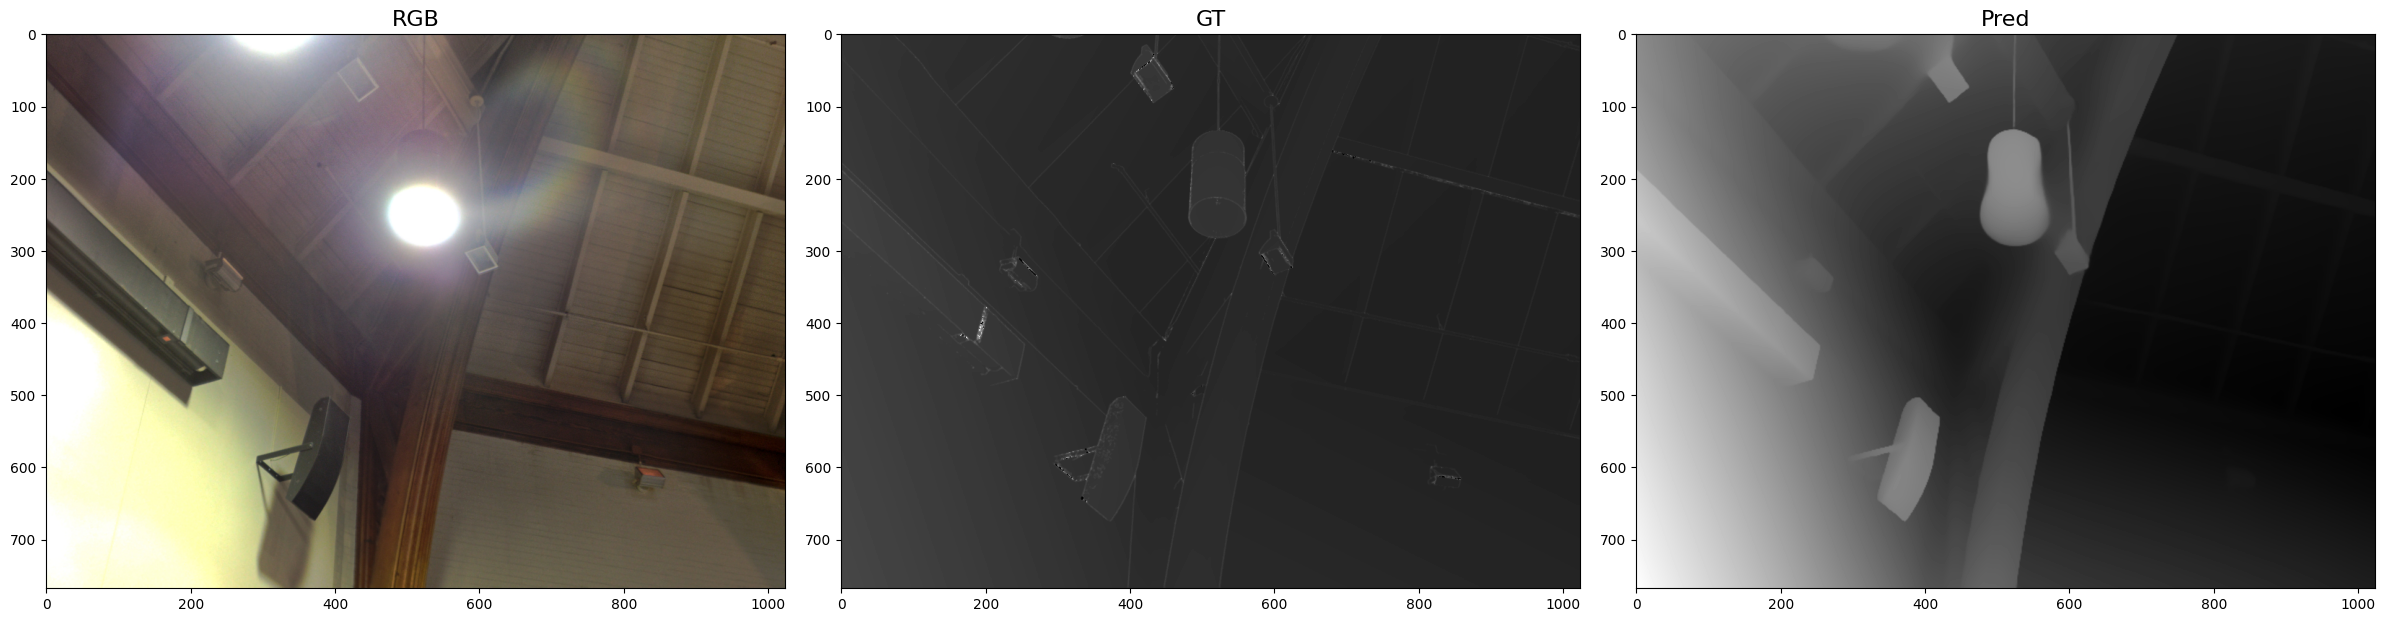

---- Depth Report ----

Unique values: [0.         0.06019246 0.06594539 ... 0.7368225  0.7440759  0.74411136]
how many uniques: 728459
Max: 0.7441113591194153
Min: 0.0
shape: (768, 1024, 1)
Has nan: False
Dtype: float32
---- Depth Report ----

Unique values: [ 19.541471  19.544458  19.593042 ... 510.51886  510.80557  511.08362 ]
how many uniques: 776363
Max: 511.0836181640625
Min: 19.541471481323242
shape: (768, 1024)
Has nan: False
Dtype: float32


In [68]:
show_pred_gt(rgb, disparity_masked ,pred_diode)

In [69]:
flat_disparity_gt = disparity_masked.flatten()
flat_mask = mask.astype(bool).flatten()
flat_disparity_gt_masked = flat_disparity_gt[flat_mask] #ESTE AQUI É O GT FLAT 

In [70]:
flat_pred = pred_diode.flatten()
flat_pred_masked = flat_pred[flat_mask] # ESTE AQUI É O PRED FLAT

In [71]:
A = np.vstack([flat_disparity_gt_masked, np.ones(len(flat_disparity_gt_masked))]).T
s, t = np.linalg.lstsq(A, flat_pred_masked, rcond=None)[0]
depth_aligned = (pred_diode - t) / s


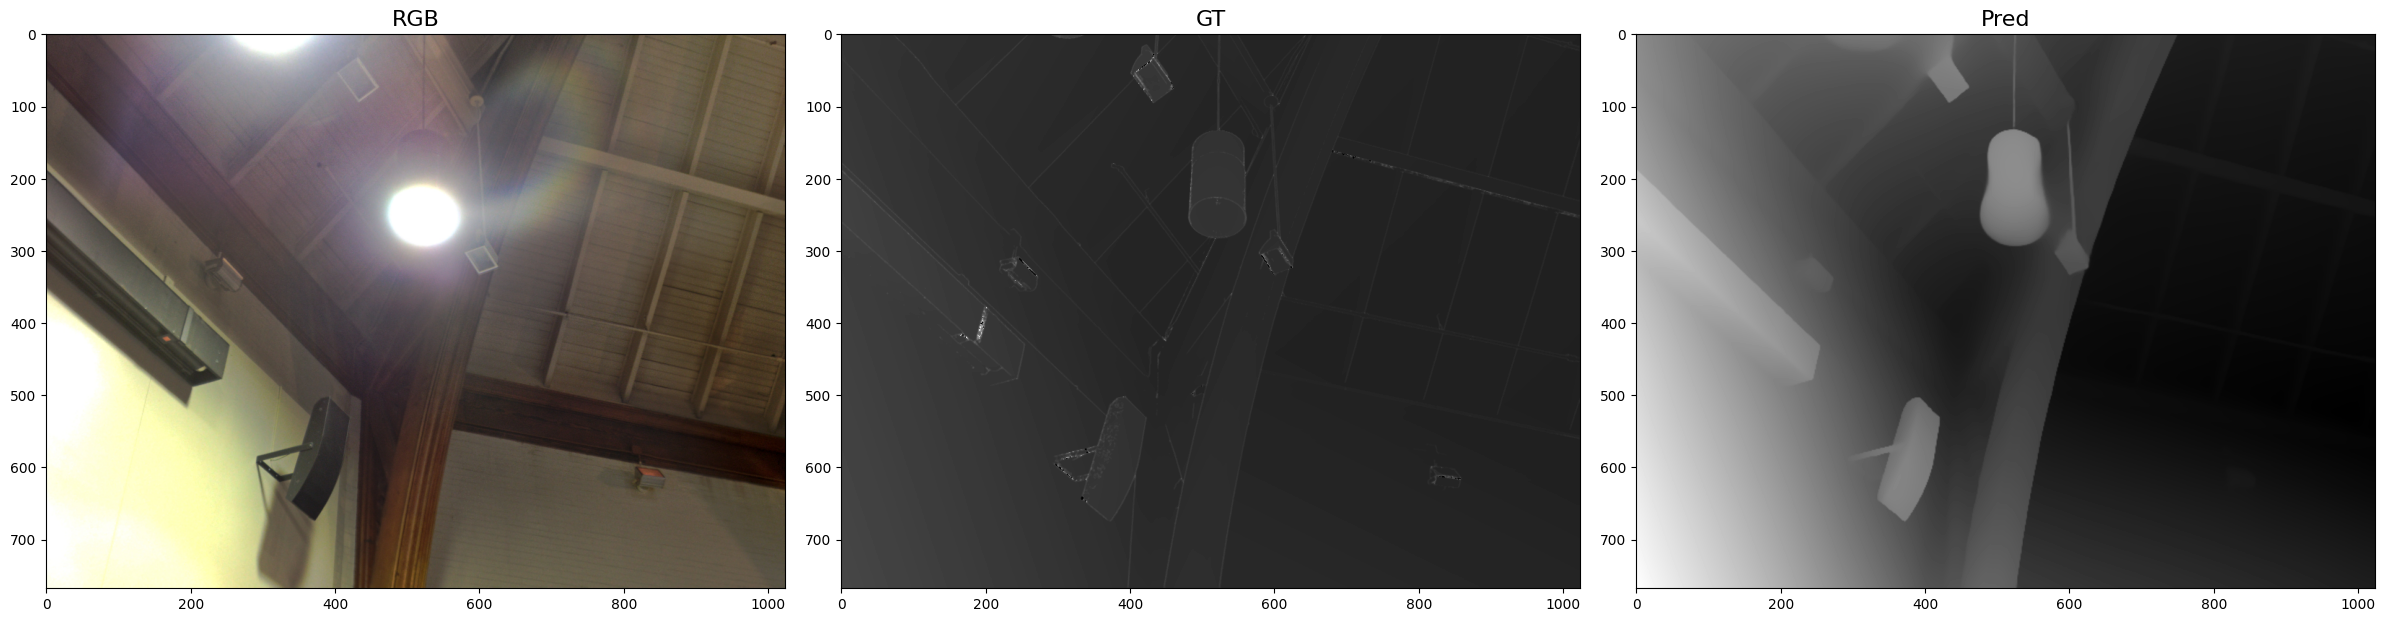

---- Depth Report ----

Unique values: [0.         0.06019246 0.06594539 ... 0.7368225  0.7440759  0.74411136]
how many uniques: 728459
Max: 0.7441113591194153
Min: 0.0
shape: (768, 1024, 1)
Has nan: False
Dtype: float32
---- Depth Report ----

Unique values: [0.08873197 0.08873279 0.08874611 ... 0.22332841 0.22340701 0.22348324]
how many uniques: 776363
Max: 0.223483235902713
Min: 0.08873197408397307
shape: (768, 1024)
Has nan: False
Dtype: float64


In [72]:
show_pred_gt(rgb, disparity_masked ,depth_aligned)

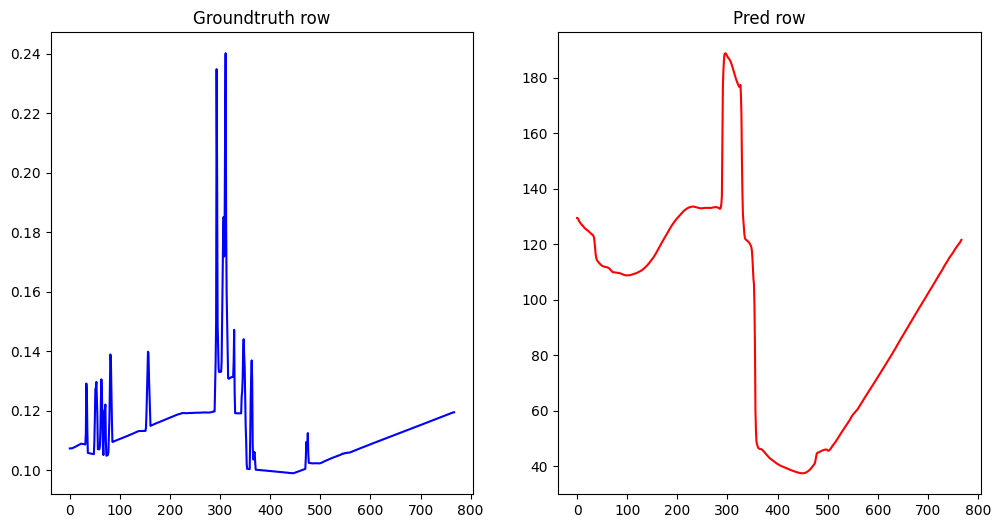

In [77]:
row_index = round(W*(6/10))
disp_row = disparity_masked[:, row_index]
disp_row = disp_row.reshape(H)
pred_row = pred_diode[:, row_index]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(disp_row, 'b')
plt.title("Groundtruth row")
plt.subplot(1,2,2)
plt.plot(pred_row, 'r')
plt.title("Pred row")
plt.show()

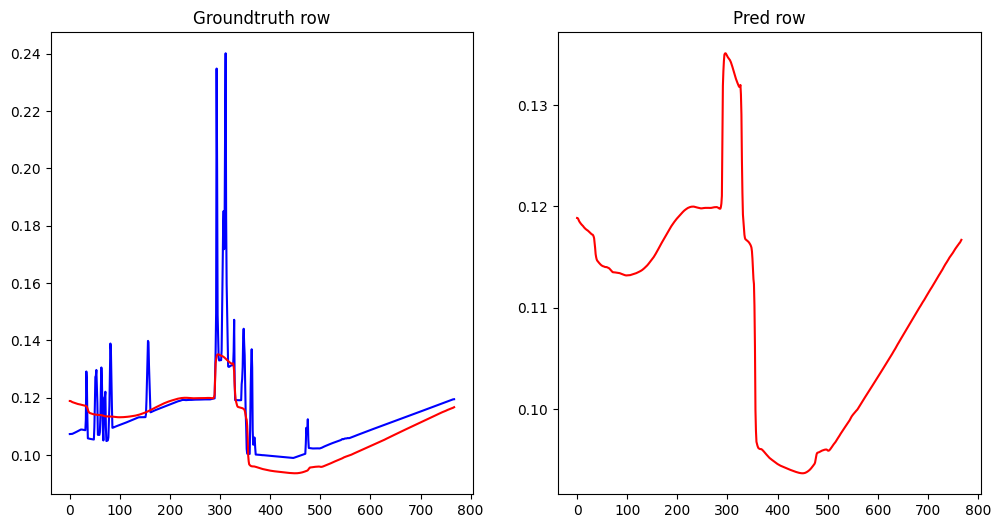

In [78]:
disp_row = disparity_masked[:, row_index]
disp_row = disp_row.reshape(H)
pred_row = depth_aligned[:, row_index]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot( disp_row, 'b', pred_row, 'r')
plt.title("Groundtruth row")
plt.subplot(1,2,2)
plt.plot( pred_row, 'r')
plt.title("Pred row")
plt.show()

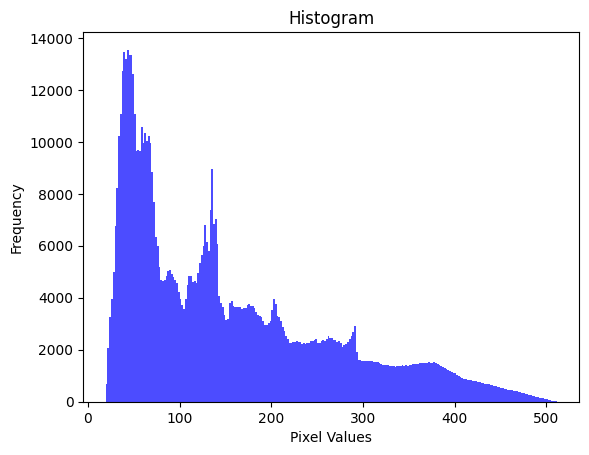

In [75]:
plot_histogram(pred_diode)

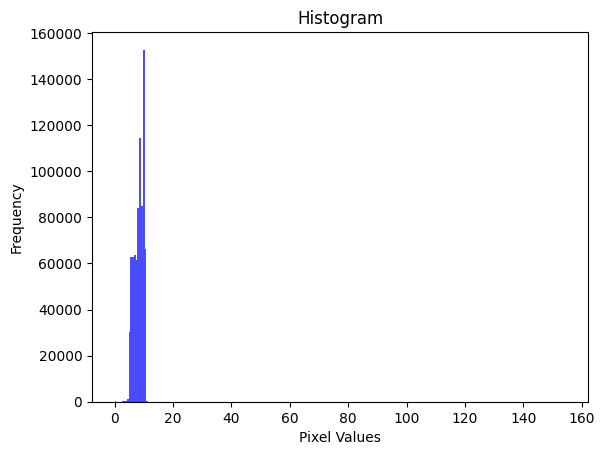

In [76]:
plot_histogram(groundtruth)